# Custom BERT Keras Layer

A simple example to demonstrate how to create a Keras model which includes BERT as a layer.

In [1]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import layers

import bert_utils

### Model Parameters

In [3]:
BERTLARGE   = False
MAX_SEQ_LEN = 512

if BERTLARGE:
    # TFHub module for BERTLARGE (330M)
    BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-24_H-1024_A-16/1"
    H_SIZE    = 1024
else:
    # TFHub module for BERTBASE (110M)
    BERT_PATH = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
    H_SIZE    = 768

In [4]:
config = tf.ConfigProto()
# allow us to instrument the GPU VRAM usage
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.keras.backend.set_session(sess)

## Creating the Model

### Model Inputs

We have three seperate inputs:

* `in_token`: Sequence of id of tokens (WordPiece)
* `in_mask`: Sequence of `0`/`1` indicating mask
* `in_segment`: Sequence of `0`/`1` indicating which segment the tokens belong to (for multi-sentence input)

In [5]:
in_token = layers.Input(shape=(MAX_SEQ_LEN,), name="input_tokens")
in_mask = layers.Input(shape=(MAX_SEQ_LEN,), name="input_masks")
in_segment = layers.Input(shape=(MAX_SEQ_LEN,), name="segment_ids")

In [6]:
in_bert = [in_token, in_mask, in_segment]

### BERT Layer

To build the BERT layer, we specify:

* `fine_tune_layers`: how many Transformer blocks to fine-tune
* `bert_path`: URL of TFHub module
* `return_sequence`: Return sequence of representations (one per token) or just for the `[CLS]` token
* `output_size`: Size of output representation (768 for `BERTBASE`, 1024 for `BERTLARGE`)
* `debug`: Print debug output (including list of trainable variables)

In [7]:
bert_layer = bert_utils.BERT(fine_tune_layers=-1,
                             bert_path=BERT_PATH,
                             return_sequence=False,
                             output_size=H_SIZE,
                             debug=False)
l_bert = bert_layer(in_bert)
bert_output_shape = bert_layer.compute_output_shape((1,MAX_SEQ_LEN))
l_bert = layers.Reshape(bert_output_shape)(l_bert)

print("BERT Output", l_bert.shape)

Input: (1, 512)
BERT Output (?, 768)


In [8]:
bert_output_shape

(768,)

### Build Keras Model

In [9]:
# classification (softmax) layer
out_pred = layers.Dense(1, activation="softmax")(l_bert)

# build Keras model
model = tf.keras.models.Model(inputs=in_bert, outputs=out_pred)

W0804 16:43:55.254714 140587665684288 deprecation.py:506] From /home/jovyan/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Model Information

**Model Architecture**

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tokens (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (BERT)                     (None, 768)          110104890   input_tokens[0][0]               
                                                                 input_masks[0][0]            

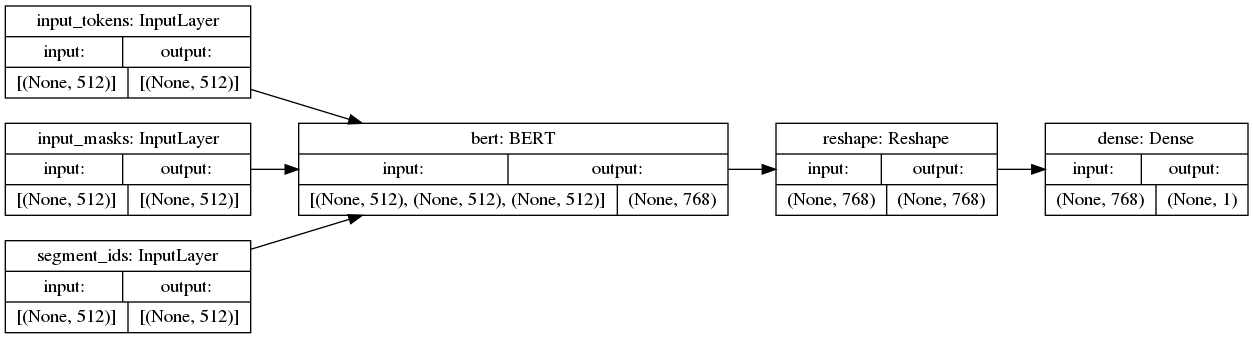

In [11]:
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir="LR")